# The Scrödinger Equation in 2D

The Time Independent Schrodinger Equation in 2D: 

$$ -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial \vec{r}^2}\psi(\vec{r},t) + V(\vec{r}) \psi(\vec{r},t) = E \psi(\vec{r},t) $$
$$ \psi(0) = \psi(L) = 0 $$

To solve our equation, we will be constructing a sparse matrix and transforming our original equation
$$ -\frac{\hbar^2}{2m}\left(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}\right)\psi + V \psi = E \psi $$

to this new form using the Kronecker sum notation:
$$ -\frac{\hbar^2}{2m}\left[(D \oplus D) + m\Delta x^2 V\right]\psi= E \psi $$
$$\boxed{A \oplus B = A \otimes I + I \otimes B}$$


## How is the double derivative operator $D$ defined?

We know that

$$\frac{\partial \psi_{i}^{2}}{\partial x^2} \approx \frac{\psi_{i+1} -2\psi_{i} + \psi_{i-1}}{\Delta x^2} $$

More specifically
$$ 1\psi_{i+1} + (2 m \Delta x^{2} V_{i} - 2)\psi_{i} + 1\psi_{i-1} = 2 m \Delta x^2 E \psi_{i}$$

Let $\sigma = (2 m \Delta x^{2} V_{i} - 2)$. Then we construct a matrix system $Ax = y$
$$ \begin{bmatrix} \sigma_{1} & 1 &  0 & ... & ... & ... & 0\\ 1 & \sigma_{2} & 1 & 0 & ... & ... & 0 \\ 0 & 1 & \sigma_{2} & 1 & 0 & ... & 0 \\...& ... & ... &... &... &... &... & \\... & ... & ... & ... & 0 & 1 & \sigma_{N}\\ \end{bmatrix} \begin{bmatrix} \psi_1 \\ \psi_2 \\ \psi_3 \\ ... \\ \psi_{N} \end{bmatrix} = 2 m \Delta x^2 \begin{bmatrix} \psi_1 \\ \psi_2 \\ \psi_3 \\ ... \\ \psi_{N} \end{bmatrix}  $$

Specifically for X direction we get

$$\frac{1}{\Delta x^2} \begin{bmatrix} -2 & 1 & 0\\ 1 & -2 & 1 \\ 0 & 1 & -2\\ \end{bmatrix} \equiv D_{x} \hspace{10mm} I \otimes D_X = \frac{1}{\Delta x^2} \begin{bmatrix} D & 0 & 0\\ 0 & D & 0 \\ 0 & 0 & D\\ \end{bmatrix}$$

and for Y
$$D_y \otimes I = \frac{1}{\Delta y^2} \begin{bmatrix} -2I & 1I & 0\\ 1I & -2I & 1I \\ 0 & 1I & -2I\\ \end{bmatrix} \hspace{10mm} I = \begin{bmatrix} 1 & 0 & 0\\ 0 & 1 & 0 \\ 0 & 0 & 1\\ \end{bmatrix}$$

In [2]:
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
#plt.style.use(['science', 'notebook'])
from scipy import sparse

Create a meshgrid of $x$ and $y$ coordinates

In [3]:
N = 150
X, Y = np.meshgrid(np.linspace(0,1,N, dtype=float),
                   np.linspace(0,1,N, dtype=float))

Our equation is

$$\left[-\frac{1}{2}(D \oplus D) + m\Delta x^2 V \right] \psi = \left(m \Delta x^2 E\right) \psi$$

where $D$ has -2 on the main diagonal and 1 on the two neighbouring diagonals, $\psi$ is a vector. Firstly, we define our potential in units of $m \Delta x^2$; in other words `get_potential` actually returns $m\Delta x^2 V$

In [4]:
#def get_potential(x,y):
#    return 0*x
def get_potential(x, y):
    return np.exp(-(x-0.3)**2/(2*0.1**2))*np.exp(-(y-0.3)**2/(2*0.1**2))
V = get_potential(X,Y)

Now we construct

$$- \frac{1}{2} D \oplus D + m\Delta x^2 V $$

Let $T=- \frac{1}{2} D \oplus D$ and $U = 2m\Delta x^2 V$

For reference:
* U is $N \times N$

$$ D = \begin{bmatrix} -2 & 1 &  0 & ... & ... & ... & 0\\ 1 & -2 & 1 & 0 & ... & ... & 0 \\ 0 & 1 & -2 & 1 & 0 & ... & 0 \\...& ... & ... &... &... &... &... & \\... & ... & ... & ... & 0 & 1 & -2\\ \end{bmatrix} \hspace{10mm} T = D \oplus D $$

* $V$ matrix is for 1D $N \times N$
* U is for 2D $N^2 \times N^2$:
$$V = \begin{bmatrix} V_{11} & V_{12} &  ... & V_{1N} \\ V_{21} & V_{22} &  ... & V_{2N} \\ ...& ... & ... &... \\V_{N1} & V_{2N} & ... & V_{NN}\\ \end{bmatrix} \hspace{10mm} U = \begin{bmatrix} V_{11} & 0 &  ... & 0 \\ 0 & V_{12} &  ... & 0 \\ ...& ... & ... &... \\0 & 0 & ... & V_{NN}\\ \end{bmatrix}$$

In [5]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])
D = sparse.spdiags(diags, np.array([-1,0,1]), N, N) #-1 index - one line below main diag; 0 - main diagonal; 1 - one line above main diag line
T = -1/2 * sparse.kronsum(D,D)
U = sparse.diags(V.reshape(N**2), (0))
H = T+U

Get eigenvectors and eigenvalues

In [6]:
eigenvalues, eigenvectors = eigsh(H, k=10, which='SM') # 'SM' means the smallest eigenvectors

In [7]:
def get_e(n): # function for plotting
    return eigenvectors.T[n].reshape((N,N))

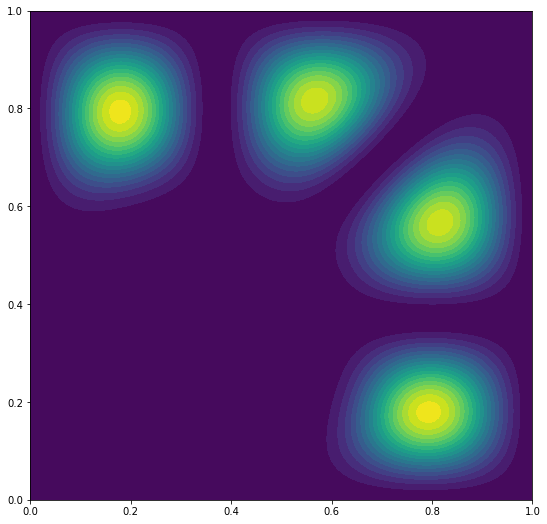

In [8]:
plt.figure(figsize=(9,9))
plt.contourf(X, Y, get_e(3)**2, 20)

Animation code

/tmp/ipykernel_40236/1128550605.py:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


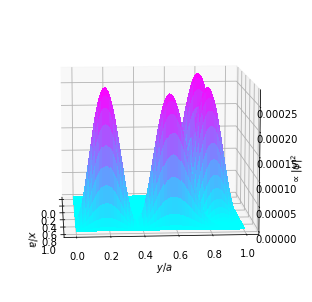

In [9]:
my_cmap = plt.get_cmap('cool')
def init():
    # Plot the surface.
    ax.plot_surface(X, Y, get_e(3)**2, cmap=my_cmap,
                       linewidth=0, antialiased=False)
    ax.set_xlabel('$x/a$')
    ax.set_ylabel('$y/a$')
    ax.set_zlabel('$\propto|\psi|^2$')
    return fig,

def animate(i):
    ax.view_init(elev=10, azim=4*i)
    return fig,

fig = plt.figure()
ax = Axes3D(fig)
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=90, interval=50)
ani.save('rotate_azimuth_angle_3d_surf.gif',writer='pillow',fps=20)

**For infinite square well only**: Note that $E_{n_x, n_y} = \alpha ( n_x^2 + n_y^2 ) $. First energy at $n_x=1$ and $n_y=1$. This means we can find $\alpha = \text{half the lowest eigenvalue}$ and we can plot $E/\alpha$ which should be distributed like $n_x^2 + n_y^2$ for different combinations of $n_x$ and $n_y$.

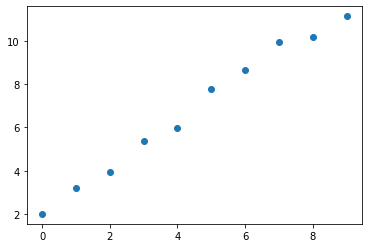

In [10]:
alpha = eigenvalues[0]/2
E_div_alpha = eigenvalues/alpha
_ = np.arange(0, len(eigenvalues), 1)
plt.scatter(_, E_div_alpha)
#[plt.axhline(nx**2 + ny**2,color='r') for nx in range(1,5) for ny in range(1,5)]